In [1]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as sm
import numpy as np
import patsy

In [2]:
interim = '../data/interim'

In [3]:
gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')

gl['DH_FL'] = gl.filter(regex='.*Batting.Position').isin([10]).max(axis=1).astype('int')
gl = gl.loc[:, ['GAME_ID', 'HomeH', 'VisitorH', 'ParkID', 'HomeTeam', 'VisitingTeam', 'year', 'DH_FL']]
gl = gl.astype({
    'HomeH': 'float',
    'VisitorH': 'float',
    'ParkID': 'object',
    'HomeTeam':'object',
    'VisitingTeam': 'object',
})
gl = gl.rename(columns={
    'HomeH': 'H_Home',
    'VisitorH': 'H_Visitor',
})
gl = gl.dropna()

gl = pd.wide_to_long(
    gl , ['H'] , i=['GAME_ID', 'year', 'HomeTeam', 'VisitingTeam'],
    j='Home', sep='_', suffix=r'\w+'
)

gl = gl.reset_index().set_index(['GAME_ID'])
gl['BatTeam'] = np.where(
    gl['Home'] == 'Home',
    gl['HomeTeam'],
    gl['VisitingTeam']
)

gl['FieldTeam'] = np.where(
    gl['Home'] == 'Home',
    gl['VisitingTeam'],
    gl['HomeTeam']
)

gl = gl[['year', 'ParkID', 'H', 'BatTeam', 'FieldTeam', 'DH_FL']]

gl['Log_H'] = np.log(gl['H'] + 1)

In [4]:
park_factors = pd.DataFrame(columns=['ParkID', 'factor_year', 'year'])

max_year = gl.year.max() + 1
min_year = gl.year.min()
for year in range(1920, max_year):
    gl_year = gl.loc[gl.year == year]

    result = sm.ols(formula="Log_H ~ C(ParkID) + C(BatTeam) + C(FieldTeam)", data=gl_year).fit()

    test = pd.DataFrame(result.params)
    test = test.reset_index()
    test.columns = ['ParkID', 'factor_year']

    ParkFactors = test.loc[test.ParkID.str.contains('ParkID'), ['ParkID', 'factor_year']]

    ParkFactors['ParkID'] = ParkFactors.ParkID.str.slice(start=-6, stop=-1)

    mat = patsy.dmatrix("C(ParkID)", gl_year)
    di = mat.design_info
    fi = di.factor_infos
    fi2 = fi[list(di.factor_infos.keys())[0]]
    omitted = fi2.categories[0]
    
    ParkFactors = ParkFactors.append({'ParkID':omitted, 'factor_year':0}, ignore_index=True)
    
    ParkFactors['year'] = year
    
    park_factors = park_factors.append(ParkFactors)
    
park_factors = park_factors.sort_values(['ParkID', 'year'])
park_factors = park_factors.set_index(['ParkID', 'year'])

ObsCount = gl.groupby(['ParkID', 'year'])[['ParkID']].count()
ObsCount.columns = ['N']

park_factors = pd.merge(park_factors, ObsCount, on=['ParkID', 'year'])

In [5]:
park_factors = park_factors.sort_values(['ParkID', 'year'])

In [6]:
park_factors['lag_factor_year'] = park_factors.groupby('ParkID')['factor_year'].shift(1)

<AxesSubplot:>

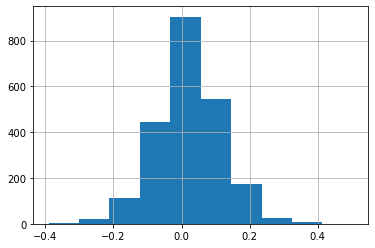

In [7]:
park_factors['factor_year'].hist()

In [8]:
result = sm.ols(formula="factor_year ~ lag_factor_year", data=park_factors).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            factor_year   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     681.7
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          8.83e-131
Time:                        21:43:11   Log-Likelihood:                 2306.0
No. Observations:                2154   AIC:                            -4608.
Df Residuals:                    2152   BIC:                            -4597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0097      0.002     

<AxesSubplot:xlabel='lag_factor_year', ylabel='factor_year'>

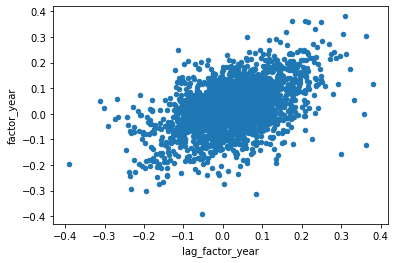

In [9]:
park_factors.plot.scatter(x='lag_factor_year', y='factor_year')

In [10]:
park_factors['factor'] = park_factors.groupby('ParkID')['factor_year'].transform(lambda x: x.rolling(3, 1).mean())

In [11]:
# park_factors['L1_factor_year'] = park_factors.groupby('ParkID')['factor_year'].shift(1, fill_value=0)
# park_factors['L2_factor_year'] = park_factors.groupby('ParkID')['factor_year'].shift(2, fill_value=0)
# park_factors['L3_factor_year'] = park_factors.groupby('ParkID')['factor_year'].shift(3, fill_value=0)
# park_factors['L4_factor_year'] = park_factors.groupby('ParkID')['factor_year'].shift(4, fill_value=0)

In [12]:
# park_factors['factor'] = (
#     5 * park_factors['L1_factor_year'] +
#     2 * park_factors['L2_factor_year'] +
#     1 * park_factors['L3_factor_year']
# )/8

In [13]:
park_factors['L1_factor'] = park_factors.groupby('ParkID')['factor'].shift(1)

                            OLS Regression Results                            
Dep. Variable:            factor_year   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     910.4
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          4.31e-167
Time:                        21:43:11   Log-Likelihood:                 2389.6
No. Observations:                2154   AIC:                            -4775.
Df Residuals:                    2152   BIC:                            -4764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0056      0.002      3.156      0.0

<AxesSubplot:xlabel='L1_factor', ylabel='factor_year'>

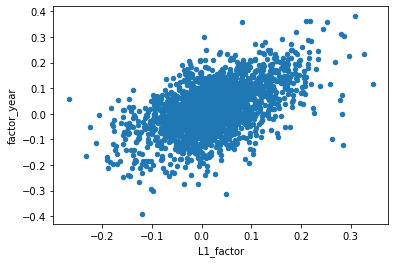

In [14]:
result = sm.ols(formula="factor_year ~ L1_factor", data=park_factors).fit()
print(result.summary())

park_factors.plot.scatter(x='L1_factor', y='factor_year')

In [15]:
# result = sm.ols(formula="factor_year ~ L1_factor_year + L2_factor_year + L3_factor_year + L4_factor_year", data=park_factors).fit()
# print(result.summary())